This code is derived from https://github.com/andersy005/deep-frameworks-quest/blob/master/CIFAR-10/PyTorch-CIFAR-10.ipynb and was slightly modified to run on Google Colab.

<h1 align="center"> CIFAR-10 - Object Recognition in Images </h1>
![](http://pytorch.org/tutorials/_images/cifar10.png)

## Data Introduction
The CIFAR-10 data consists of **60,000** 32x32 color images in **10 classes**, with 6000 images per class. There are **50,000 training images** and **10,000 test images** in the official data.

CIFAR-10 has the classes: 
- airplane 
- automobile 
- bird
- cat 
- deer
- dog
- frog
- horse
- ship
- truck


## Import Packages


In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install bokeh

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import bokeh
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV
import pickle
import sklearn
from __future__ import print_function
%matplotlib inline

In [0]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The PyTorch version is {}.'.format(torch.__version__))
print('The NumPy version is {}.'.format(np.__version__))
print('The Matplotlib version is {}.'.format(mpl.__version__))

The scikit-learn version is 0.19.2.
The PyTorch version is 0.4.1.
The NumPy version is 1.14.6.
The Matplotlib version is 2.1.2.


## Training an image classifier

We will do the following steps in order.

### Step1: Load and normalizing the CIFAR10 training and test datasets using ```torchvision```

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]

The ```transforms.Compose(transforms)``` class Composes several transforms together.

<p  style="color:blue;"> Parameters:</p>
<ul  style="color:red;">
    <li>  transforms (List[Transform]): – list of transforms to compose.</li>
</ul>

In our case we are going to do two transforms:
- ```ToTensor()```
- ```Normalize()```


In [0]:
transform = transforms.Compose(
             [transforms.ToTensor(), 
              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [0]:
# Load the training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                                        transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=5,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=5,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#### Data Exploration
Let's plot some training images

In [0]:
def plot_images(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    
    

    frog     bird    plane      dog    truck


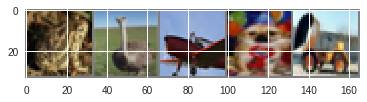

In [0]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Plot images
plot_images(torchvision.utils.make_grid(images, nrow=5, padding=1))

# print labels
print(' '.join('%8s' % classes[labels[j]] for j in range(5)))

### Step2: Define a Convolution Neural Network

- [```nn.Module```](http://pytorch.org/docs/nn.html#torch.nn.Module): Base class for all neural network module. All models should also subclass this class.

- [```nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)```](http://pytorch.org/docs/nn.html#torch.nn.Conv2d)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [0]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Step3: Define a Loss function and Optimizer
We will use a Classification Cross-Entropy loss and SGD with momentum.

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Step4: Train the network


In [0]:
def training(num_iterations):
    for epoch in range(num_iterations): # loop over the dataset multiple times
        print('Training: Epoch - (%d)'%(epoch))
        running_loss = 0.0
        
        for i, data in enumerate(trainloader, 0):
            # Get the inputs
            inputs, labels = data
            
            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            
            # Print statistics
            running_loss += loss.item()
            
            if i % 2000 == 1999: # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
                
                running_loss = 0.0
                
    print('Finished Training')

In [0]:
training(num_iterations=5)

Training: Epoch - (0)
[1,  2000] loss: 1.943
[1,  4000] loss: 1.740
[1,  6000] loss: 1.611
[1,  8000] loss: 1.550
[1, 10000] loss: 1.498
Training: Epoch - (1)
[2,  2000] loss: 1.441
[2,  4000] loss: 1.403
[2,  6000] loss: 1.359
[2,  8000] loss: 1.341
[2, 10000] loss: 1.332
Training: Epoch - (2)
[3,  2000] loss: 1.251
[3,  4000] loss: 1.253
[3,  6000] loss: 1.221
[3,  8000] loss: 1.223
[3, 10000] loss: 1.197
Training: Epoch - (3)
[4,  2000] loss: 1.130
[4,  4000] loss: 1.129
[4,  6000] loss: 1.127
[4,  8000] loss: 1.132
[4, 10000] loss: 1.121
Training: Epoch - (4)
[5,  2000] loss: 1.041
[5,  4000] loss: 1.047
[5,  6000] loss: 1.062
[5,  8000] loss: 1.058
[5, 10000] loss: 1.052
Finished Training


### Step5: Test the network on the test data
Let's see if the network has learned anything after 5 passes over the training dataset.


GroundTruth: 
      cat     ship     ship    plane     frog
Predicted: 
      cat      car      car    plane      cat


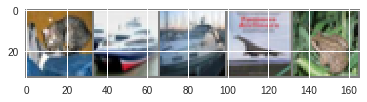

In [0]:
# plot some images from the test dataset
dataiter = iter(testloader)
images, labels = dataiter.next()

# plot images
plot_images(torchvision.utils.make_grid(images,nrow=5, padding=1))

print('GroundTruth: \n', ' '.join('%8s' % classes[labels[j].item()] for j in range(5)))

# predict class labels for test images
outputs = net(Variable(images))

_, predicted = torch.max(outputs.data, 1)

print('Predicted: \n', ' '.join('%8s' % classes[predicted[j].item()]
                              for j in range(5)))

#### Model Accuracy Evaluation

In [0]:

correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))    


Accuracy of the network on the 10000 test images: 60 %


#### what are the classes that performed well, and the classes that did not perform well

In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(5):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1

for i in range(10):
    print('Accuracy of {} : {}'.format(classes[i], 100 * class_correct[i] / class_total[i])
)

Accuracy of plane : 71.1
Accuracy of car : 71.0
Accuracy of bird : 36.1
Accuracy of cat : 47.0
Accuracy of deer : 41.4
Accuracy of dog : 54.0
Accuracy of frog : 67.4
Accuracy of horse : 78.1
Accuracy of ship : 65.8
Accuracy of truck : 70.8
